<a href="https://colab.research.google.com/github/Higgins2718/DS-Unit-1-Sprint-1-Dealing-With-Data/blob/master/module1-afirstlookatdata/LS_DS_111_A_First_Look_at_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - A First Look at Data



## Lecture - let's explore Python DS libraries and examples!

The Python Data Science ecosystem is huge. You've seen some of the big pieces - pandas, scikit-learn, matplotlib. What parts do you want to see more of?

In [2]:
# TODO - we'll be doing this live, taking requests
# and reproducing what it is to look up and learn things

1 + 1

2

## Assignment - now it's your turn

Pick at least one Python DS library, and using documentation/examples reproduce in this notebook something cool. It's OK if you don't fully understand it or get it 100% working, but do put in effort and look things up.

In [75]:
!pip install boilerpipe3

    100% |████████████████████████████████| 1.3MB 16.0MB/s 
    100% |████████████████████████████████| 92kB 25.9MB/s 
    100% |████████████████████████████████| 174kB 23.7MB/s 
  Stored in directory: /root/.cache/pip/wheels/b9/fd/7e/8db2c536d1946876d32cc990bf9e9ea255c563ccf8a76dc25d
  Stored in directory: /root/.cache/pip/wheels/76/7d/41/829109c81b0c4bdca8047fb9e0a573d4db3b671fbbe84a84f3
  Stored in directory: /root/.cache/pip/wheels/17/e4/b6/f27d4d6c000855ea7180a28099cd8d758b1d5debce4fac2d65
Successfully built boilerpipe3 JPype1-py3 charade


In [94]:
import httplib2
import re
from bs4 import BeautifulSoup

http = httplib2.Http()
status, response = http.request('https://www.nytimes.com/section/opinion/editorials')

soup = BeautifulSoup(response, 'html5lib')

#links = []
 
#for link in soup.findAll('a', attrs={'href': re.compile("^http(s?)://")}):
    #links.append(link.get('href'))

#for link in links:
    #print(link)
mydivs = soup.findAll('h2', class_="css-1dq8tca e1xfvim30")
headlines = []
for div in mydivs:
  print(div.getText())
  headlines.append(div.getText())
#print(mydivs)
# css-1dq8tca e1xfvim30

China’s Brutal ‘Boarding Schools’
Trump Wants to Eliminate H.I.V. But Some of His Policies Do the Opposite.
How to Challenge Albany’s Corrupt Culture
‘The President … Is Not Above the Law’
Why Does the U.S. Tolerate So Much Risk?
The New Zealand Massacre Was Made to Go Viral
Senate Republicans’ Declaration of (Semi-) Independence
American Gun Culture Goes on Trial
The Man Who Changed the Constitution, Twice
Her Crime? Defending Women’s Rights in Iran


In [0]:
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

In [108]:
proper_noun = []
for item in headlines:
    tokens = nltk.word_tokenize(item,)
    tokenized = nltk.pos_tag(tokens)
    #print(tokenized)


    for t in tokenized:
        if t[1].startswith("NNP"):
            #print(tokenized.index(t))
            index_num = tokenized.index(t)
            #print(t[0])
            if index_num == 0:
                next_item = tokenized[1]
                if next_item[1].startswith("NNP"):
                    pn = t[0] + " " + next_item[0]
                    proper_noun.append(pn)
                    print(pn.replace(" ’", "").replace(" …", ""))
                else:
                    pass
                    #print("Second char isn't proper noun")
            elif index_num != 0 and t[0] not in str(proper_noun) and index_num != len(tokenized)-1:
                #print("ADDITIONAL ", t[0])
                if tokenized[int(index_num + 1)][1].startswith("NNP"):
                    pn = t[0] + " " + tokenized[int(index_num + 1)][0]
                    print(pn.replace(" ’", "").replace(" …", ""))



China
Brutal ‘
‘ Boarding
Boarding Schools
Albany
President
U.S. Tolerate
New Zealand
Zealand Massacre
Massacre Was
Was Made
Senate Republicans
American Gun
Culture Goes
Women


BONUS:

In [0]:
import numpy as np
import pylab as pl
from scipy import interpolate, signal
import matplotlib.font_manager as fm


# We need a special font for the code below.  It can be downloaded this way:
import os
import urllib.request
if not os.path.exists('Humor-Sans.ttf'):
    fhandle = urllib.request.urlopen('http://antiyawn.com/uploads/Humor-Sans-1.0.ttf')
    open('Humor-Sans.ttf', 'wb').write(fhandle.read())
    
def xkcd_line(x, y, xlim=None, ylim=None,
              mag=1.0, f1=30, f2=0.05, f3=15):
    """
    Mimic a hand-drawn line from (x, y) data

    Parameters
    ----------
    x, y : array_like
        arrays to be modified
    xlim, ylim : data range
        the assumed plot range for the modification.  If not specified,
        they will be guessed from the  data
    mag : float
        magnitude of distortions
    f1, f2, f3 : int, float, int
        filtering parameters.  f1 gives the size of the window, f2 gives
        the high-frequency cutoff, f3 gives the size of the filter
    
    Returns
    -------
    x, y : ndarrays
        The modified lines
    """
    x = np.asarray(x)
    y = np.asarray(y)
    
    # get limits for rescaling
    if xlim is None:
        xlim = (x.min(), x.max())
    if ylim is None:
        ylim = (y.min(), y.max())

    if xlim[1] == xlim[0]:
        xlim = ylim
        
    if ylim[1] == ylim[0]:
        ylim = xlim

    # scale the data
    x_scaled = (x - xlim[0]) * 1. / (xlim[1] - xlim[0])
    y_scaled = (y - ylim[0]) * 1. / (ylim[1] - ylim[0])

    # compute the total distance along the path
    dx = x_scaled[1:] - x_scaled[:-1]
    dy = y_scaled[1:] - y_scaled[:-1]
    dist_tot = np.sum(np.sqrt(dx * dx + dy * dy))

    # number of interpolated points is proportional to the distance
    Nu = int(200 * dist_tot)
    u = np.arange(-1, Nu + 1) * 1. / (Nu - 1)

    # interpolate curve at sampled points
    k = min(3, len(x) - 1)
    res = interpolate.splprep([x_scaled, y_scaled], s=0, k=k)
    x_int, y_int = interpolate.splev(u, res[0]) 

    # we'll perturb perpendicular to the drawn line
    dx = x_int[2:] - x_int[:-2]
    dy = y_int[2:] - y_int[:-2]
    dist = np.sqrt(dx * dx + dy * dy)

    # create a filtered perturbation
    coeffs = mag * np.random.normal(0, 0.01, len(x_int) - 2)
    b = signal.firwin(f1, f2 * dist_tot, window=('kaiser', f3))
    response = signal.lfilter(b, 1, coeffs)

    x_int[1:-1] += response * dy / dist
    y_int[1:-1] += response * dx / dist

    # un-scale data
    x_int = x_int[1:-1] * (xlim[1] - xlim[0]) + xlim[0]
    y_int = y_int[1:-1] * (ylim[1] - ylim[0]) + ylim[0]
    
    return x_int, y_int
  
  
  
def XKCDify(ax, mag=1.0,
            f1=50, f2=0.01, f3=15,
            bgcolor='w',
            xaxis_loc=None,
            yaxis_loc=None,
            xaxis_arrow='+',
            yaxis_arrow='+',
            ax_extend=0.1,
            expand_axes=False):
    """Make axis look hand-drawn

    This adjusts all lines, text, legends, and axes in the figure to look
    like xkcd plots.  Other plot elements are not modified.
    
    Parameters
    ----------
    ax : Axes instance
        the axes to be modified.
    mag : float
        the magnitude of the distortion
    f1, f2, f3 : int, float, int
        filtering parameters.  f1 gives the size of the window, f2 gives
        the high-frequency cutoff, f3 gives the size of the filter
    xaxis_loc, yaxis_log : float
        The locations to draw the x and y axes.  If not specified, they
        will be drawn from the bottom left of the plot
    xaxis_arrow, yaxis_arrow : str
        where to draw arrows on the x/y axes.  Options are '+', '-', '+-', or ''
    ax_extend : float
        How far (fractionally) to extend the drawn axes beyond the original
        axes limits
    expand_axes : bool
        if True, then expand axes to fill the figure (useful if there is only
        a single axes in the figure)
    """
    # Get axes aspect
    ext = ax.get_window_extent().extents
    aspect = (ext[3] - ext[1]) / (ext[2] - ext[0])

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    xspan = xlim[1] - xlim[0]
    yspan = ylim[1] - xlim[0]

    xax_lim = (xlim[0] - ax_extend * xspan,
               xlim[1] + ax_extend * xspan)
    yax_lim = (ylim[0] - ax_extend * yspan,
               ylim[1] + ax_extend * yspan)

    if xaxis_loc is None:
        xaxis_loc = ylim[0]

    if yaxis_loc is None:
        yaxis_loc = xlim[0]

    # Draw axes
    xaxis = pl.Line2D([xax_lim[0], xax_lim[1]], [xaxis_loc, xaxis_loc],
                      linestyle='-', color='k')
    yaxis = pl.Line2D([yaxis_loc, yaxis_loc], [yax_lim[0], yax_lim[1]],
                      linestyle='-', color='k')

    # Label axes3, 0.5, 'hello', fontsize=14)
    ax.text(xax_lim[1], xaxis_loc - 0.02 * yspan, ax.get_xlabel(),
            fontsize=14, ha='right', va='top', rotation=12)
    ax.text(yaxis_loc - 0.02 * xspan, yax_lim[1], ax.get_ylabel(),
            fontsize=14, ha='right', va='top', rotation=78)
    ax.set_xlabel('')
    ax.set_ylabel('')

    # Add title
    ax.text(0.5 * (xax_lim[1] + xax_lim[0]), yax_lim[1],
            ax.get_title(),
            ha='center', va='bottom', fontsize=16)
    ax.set_title('')

    Nlines = len(ax.lines)
    lines = [xaxis, yaxis] + [ax.lines.pop(0) for i in range(Nlines)]

    for line in lines:
        x, y = line.get_data()

        x_int, y_int = xkcd_line(x, y, xlim, ylim,
                                 mag, f1, f2, f3)

        # create foreground and background line
        lw = line.get_linewidth()
        line.set_linewidth(2 * lw)
        line.set_data(x_int, y_int)

        # don't add background line for axes
        if (line is not xaxis) and (line is not yaxis):
            line_bg = pl.Line2D(x_int, y_int, color=bgcolor,
                                linewidth=8 * lw)

            ax.add_line(line_bg)
        ax.add_line(line)

    # Draw arrow-heads at the end of axes lines
    arr1 = 0.03 * np.array([-1, 0, -1])
    arr2 = 0.02 * np.array([-1, 0, 1])

    arr1[::2] += np.random.normal(0, 0.005, 2)
    arr2[::2] += np.random.normal(0, 0.005, 2)

    x, y = xaxis.get_data()
    if '+' in str(xaxis_arrow):
        ax.plot(x[-1] + arr1 * xspan * aspect,
                y[-1] + arr2 * yspan,
                color='k', lw=2)
    if '-' in str(xaxis_arrow):
        ax.plot(x[0] - arr1 * xspan * aspect,
                y[0] - arr2 * yspan,
                color='k', lw=2)

    x, y = yaxis.get_data()
    if '+' in str(yaxis_arrow):
        ax.plot(x[-1] + arr2 * xspan * aspect,
                y[-1] + arr1 * yspan,
                color='k', lw=2)
    if '-' in str(yaxis_arrow):
        ax.plot(x[0] - arr2 * xspan * aspect,
                y[0] - arr1 * yspan,
                color='k', lw=2)

    # Change all the fonts to humor-sans.
    prop = fm.FontProperties(fname='Humor-Sans.ttf', size=16)
    for text in ax.texts:
        text.set_fontproperties(prop)
    
    # modify legend
    leg = ax.get_legend()
    if leg is not None:
        leg.set_frame_on(False)
        
        for child in leg.get_children():
            if isinstance(child, pl.Line2D):
                x, y = child.get_data()
                child.set_data(xkcd_line(x, y, mag=10, f1=100, f2=0.001))
                child.set_linewidth(2 * child.get_linewidth())
            if isinstance(child, pl.Text):
                child.set_fontproperties(prop)
    
    # Set the axis limits
    ax.set_xlim(xax_lim[0] - 0.1 * xspan,
                xax_lim[1] + 0.1 * xspan)
    ax.set_ylim(yax_lim[0] - 0.1 * yspan,
                yax_lim[1] + 0.1 * yspan)

    # adjust the axes
    ax.set_xticks([])
    ax.set_yticks([])      

    if expand_axes:
        ax.figure.set_facecolor(bgcolor)
        ax.set_axis_off()
        ax.set_position([0, 0, 1, 1])
    
    return ax

In [12]:
%pylab inline


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['product']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


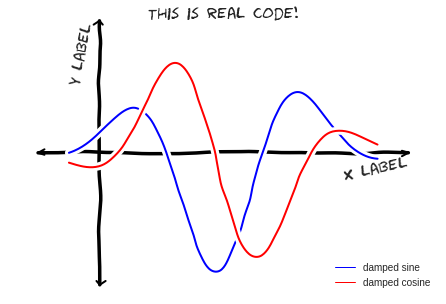

In [16]:
np.random.seed(0)

ax = pylab.axes()

x = np.linspace(0, 10, 100)
ax.plot(x, np.sin(x) * np.exp(-0.1 * (x - 5) ** 2), 'b', lw=1, label='damped sine')
ax.plot(x, -np.cos(x) * np.exp(-0.1 * (x - 5) ** 2), 'r', lw=1, label='damped cosine')

ax.set_title('This is real code!')
ax.set_xlabel('x label')
ax.set_ylabel('y label')

ax.legend(loc='lower right')

ax.set_xlim(0, 10)
ax.set_ylim(-1.0, 1.0)

#XKCDify the axes -- this operates in-place
XKCDify(ax, xaxis_loc=0.0, yaxis_loc=1.0,
        xaxis_arrow='+-', yaxis_arrow='+-',
        expand_axes=True)

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  Describe in a paragraph of text what you did and why, as if you were writing an email to somebody interested but nontechnical.

2.  What was the most challenging part of what you did?

3.  What was the most interesting thing you learned?

4.  What area would you like to explore with more time?




## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub (and since this is the first assignment of the sprint, open a PR as well).

- [pandas documentation](https://pandas.pydata.org/pandas-docs/stable/)
- [scikit-learn documentation](http://scikit-learn.org/stable/documentation.html)
- [matplotlib documentation](https://matplotlib.org/contents.html)
- [Awesome Data Science](https://github.com/bulutyazilim/awesome-datascience) - a list of many types of DS resources

Stretch goals:

- Find and read blogs, walkthroughs, and other examples of people working through cool things with data science - and share with your classmates!
- Write a blog post (Medium is a popular place to publish) introducing yourself as somebody learning data science, and talking about what you've learned already and what you're excited to learn more about.